In [7]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
out_path = "../out/bert_student_augmented/m5_k10/archived_prs0.1"

image_save_path = os.path.join('.', 'plots')

os.makedirs(image_save_path, exist_ok=True)

results_dict = {}

shen_loss_weights = ['0.5', '1', '2']
learning_rates = ['0.0002', '0.00002', '0.000002']
epochs_list = ['2', '3', '4']

for shen_loss_weight in shen_loss_weights:
    if shen_loss_weight not in results_dict:
        results_dict[shen_loss_weight] = {}
    for learning_rate in learning_rates:
        if learning_rate not in results_dict[shen_loss_weight]:
            results_dict[shen_loss_weight][learning_rate] = {}
        for epochs in epochs_list:
            version_identifier = f"shen_{shen_loss_weight}_lr{learning_rate}_e{epochs}_augmented"
            results_path = os.path.join(out_path, version_identifier, "results/results.json")
            try:
                with open(results_path, 'r') as file:
                    results = json.load(file)
                    if epochs not in results_dict[shen_loss_weight][learning_rate]:
                        results_dict[shen_loss_weight][learning_rate][epochs] = {}
                    results_dict[shen_loss_weight][learning_rate][epochs] = results
            except FileNotFoundError:
                print(f"Results file not found for version: {version_identifier}")
            except json.JSONDecodeError:
                print(f"Error decoding JSON for version: {version_identifier}")

In [9]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "serif"

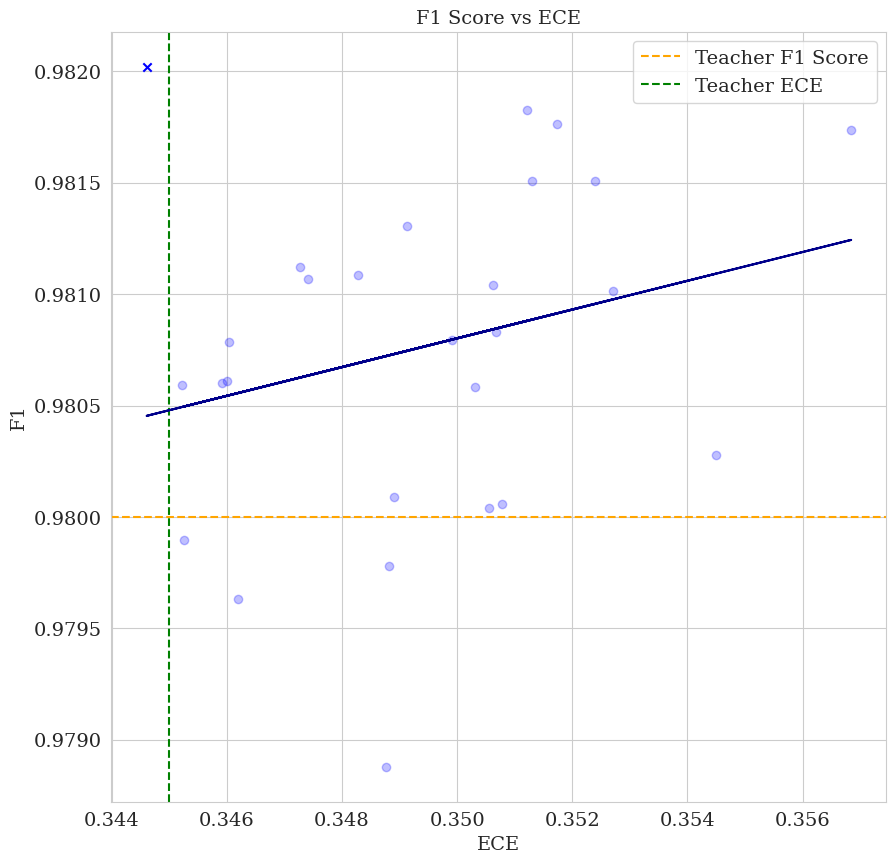

In [10]:
# plot f1 vs ECE and label with shen loss weight, learning rate and epochs
fig, ax = plt.subplots(figsize=(10, 10))

# add teacher f1 and ece as dashed lines
teacher_f1 = 0.98
teacher_ece = 0.345
ax.axhline(y=teacher_f1, color='orange', linestyle='--', label='Teacher F1 Score')
ax.axvline(x=teacher_ece, color='green', linestyle='--', label='Teacher ECE')

all_ece = []
all_f1 = []
for shen_loss_weight in shen_loss_weights:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            all_ece.append(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'])
            all_f1.append(results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'])
            
            # if f1 and ece both better than teacher, plot in dark blue, else light blue
            if results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'] > teacher_f1 and results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'] < teacher_ece:
                ax.scatter(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'], results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'], color='blue', marker='x')
            else:
                ax.scatter(results_dict[shen_loss_weight][learning_rate][epochs]['ece_score'], results_dict[shen_loss_weight][learning_rate][epochs]['f1_score'], color='blue', alpha=0.25)
            
            
            # ax.scatter(all_ece[-1], all_f1[-1])  #, label=f"shen={shen_loss_weight}, lr={learning_rate}, e={epochs}")

# Convert lists to arrays for numpy operations
all_ece = np.array(all_ece)
all_f1 = np.array(all_f1)

# Calculate linear regression
m, b = np.polyfit(all_ece, all_f1, 1)

# Calculate predictions for the trend line
predicted_f1 = m * all_ece + b

# Plot the trend line
ax.plot(all_ece, predicted_f1, color='darkblue')  #, label='Linear Trend')

ax.set_xlabel("ECE")
ax.set_ylabel("F1")
ax.set_title("F1 Score vs ECE")
ax.legend(); 

In [11]:
# find combination with ECE below 0.345 and f1 above 0.98
for shen_loss_weight in shen_loss_weights:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            f1 = results_dict[shen_loss_weight][learning_rate][epochs]['f1_score']
            ece = results_dict[shen_loss_weight][learning_rate][epochs]['ece_score']
            auc = results_dict[shen_loss_weight][learning_rate][epochs]['auc_score']
            if ece < 0.345 and f1 > 0.981:
                print(f"shen={shen_loss_weight}, lr={learning_rate}, e={epochs}, f1={f1}, ece={ece}, auc={auc}")

shen=2, lr=0.0002, e=2, f1=0.9820213799805636, ece=0.34460585905099667, auc=0.9916276484147309


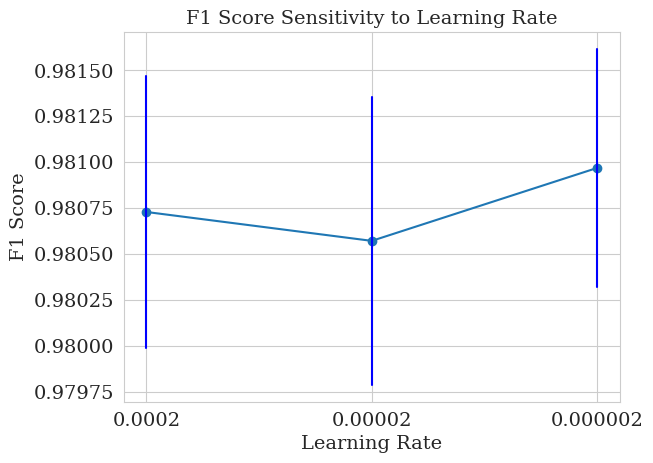

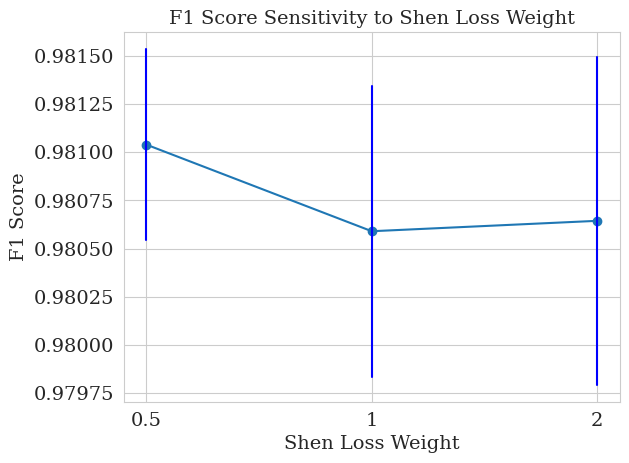

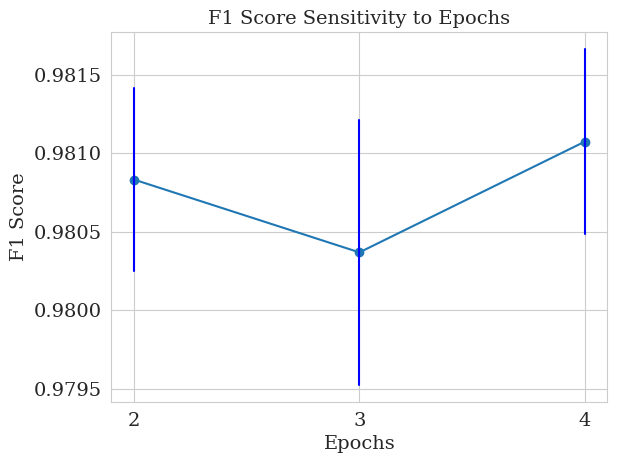

In [12]:
# Assuming `results_dict` is accessible and contains the necessary data
shen_loss_weights = ['0.5', '1', '2']
learning_rates = ['0.0002', '0.00002', '0.000002']
epochs_list = ['2', '3', '4']

def calculate_average_f1s(hyperparam, values):
    avg_f1_scores = []
    std_f1_scores = []
    for value in values:
        f1_scores = []
        for sl in shen_loss_weights:
            for lr in learning_rates:
                for ep in epochs_list:
                    if hyperparam == 'lr':
                        selected_value = lr
                    elif hyperparam == 'sl':
                        selected_value = sl
                    elif hyperparam == 'ep':
                        selected_value = ep

                    if selected_value == value:
                        f1_scores.append(results_dict[sl][lr][ep]['f1_score'])
        avg_f1_scores.append(np.mean(f1_scores))
        std_f1_scores.append(np.std(f1_scores))
    return avg_f1_scores, std_f1_scores


def plot_sensitivity(parameters_list, f1_scores_list, f1_std_list, param_name):
    plt.plot(parameters_list, f1_scores_list, marker='o', linestyle='-')
    for i, param in enumerate(parameters_list):
        plt.plot([param, param], [f1_scores_list[i] - f1_std_list[i], f1_scores_list[i] + f1_std_list[i]], color='blue')
    plt.xlabel(f'{param_name}')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score Sensitivity to {param_name}')
    plt.grid(True)
    plt.show()


avg_f1s_lr, std_f1s_lr = calculate_average_f1s('lr', learning_rates)
plot_sensitivity(learning_rates, avg_f1s_lr, std_f1s_lr, 'Learning Rate')

avg_f1s_sl, std_f1s_sl = calculate_average_f1s('sl', shen_loss_weights)
plot_sensitivity(shen_loss_weights, avg_f1s_sl, std_f1s_sl, 'Shen Loss Weight')

avg_f1s_ep, std_f1s_ep = calculate_average_f1s('ep', epochs_list)
plot_sensitivity(epochs_list, avg_f1s_ep, std_f1s_ep, 'Epochs')